This project aims to detect Pnemonia in patients through their chest X-Rays. The dataset for this project can be downloaded from: https://data.mendeley.com/datasets/rscbjbr9sj/2


In [1]:
# Magics
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import required libraries
from fastai.imports import *
from fastai.conv_learner import *
from fastai.plots import *
from fastai.sgdr import *
from fastai.transforms import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Describe the file path and batch size of images we will work with
PATH = 'data/chest-xray-pnemonia/chest_xray/'
bs = 64

### Data Visualization

In [4]:
!ls {PATH}

models	test  tmp  train  val


In [5]:
!ls '{PATH}val/PNEUMONIA'

person1946_bacteria_4874.jpeg  person1950_bacteria_4881.jpeg
person1946_bacteria_4875.jpeg  person1951_bacteria_4882.jpeg
person1947_bacteria_4876.jpeg  person1952_bacteria_4883.jpeg
person1949_bacteria_4880.jpeg  person1954_bacteria_4886.jpeg


In [6]:
!ls '{PATH}train/NORMAL'

IM-0115-0001.jpeg		NORMAL2-IM-0478-0001.jpeg
IM-0117-0001.jpeg		NORMAL2-IM-0479-0001.jpeg
IM-0119-0001.jpeg		NORMAL2-IM-0480-0001.jpeg
IM-0122-0001.jpeg		NORMAL2-IM-0481-0001.jpeg
IM-0125-0001.jpeg		NORMAL2-IM-0482-0001.jpeg
IM-0127-0001.jpeg		NORMAL2-IM-0485-0001.jpeg
IM-0128-0001.jpeg		NORMAL2-IM-0486-0001.jpeg
IM-0129-0001.jpeg		NORMAL2-IM-0487-0001.jpeg
IM-0131-0001.jpeg		NORMAL2-IM-0488-0001.jpeg
IM-0133-0001.jpeg		NORMAL2-IM-0489-0001.jpeg
IM-0135-0001.jpeg		NORMAL2-IM-0490-0001.jpeg
IM-0137-0001.jpeg		NORMAL2-IM-0491-0001.jpeg
IM-0140-0001.jpeg		NORMAL2-IM-0493-0001.jpeg
IM-0141-0001.jpeg		NORMAL2-IM-0496-0001.jpeg
IM-0143-0001.jpeg		NORMAL2-IM-0497-0001.jpeg
IM-0145-0001.jpeg		NORMAL2-IM-0499-0001.jpeg
IM-0147-0001.jpeg		NORMAL2-IM-0500-0001.jpeg
IM-0149-0001.jpeg		NORMAL2-IM-0501-0001.jpeg
IM-0151-0001.jpeg		NORMAL2-IM-0502-0001.jpeg
IM-0152-0001.jpeg		NORMAL2-IM-0503-0001.jpeg
IM-0154-0001.jpeg		NORMAL2-IM-0506-0001.jpeg
IM-0156-0001.jpeg		NORMAL2-IM-0507-0001.jpeg
IM-0158-00

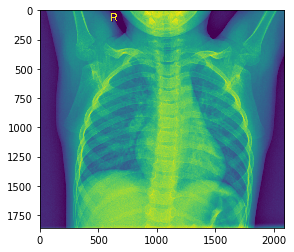

In [7]:
img = plt.imread(f'{PATH}train/NORMAL/IM-0115-0001.jpeg') 
plt.imshow(img)

In [8]:
img.shape

(1858, 2090)

## Model creation

In [17]:
# Define the image size and architecture we want to use
sz = 256
arch = resnet50

We will use the test folder for validation here, rather than the val folder, as the number of images in the val folder is too low.

In [18]:
def get_data(sz,bs=64):
    '''
    Function to get data of specified image size and in the prescribed batch size
    sz : int, size of image to be used (transformations to default image size will be applied)
    bs : int, batch size
    '''
    tfms = tfms_from_model(arch, sz=sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, bs=bs, tfms = tfms, val_name='test')

In [19]:
data = get_data(sz)

In [20]:
# Define the model
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/paperspace/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 28560137.17it/s]


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [21]:
# Find the learning rate
lr = learn.lr_find()

 63%|██████▎   | 52/82 [00:01<00:00, 41.58it/s, loss=0.576]


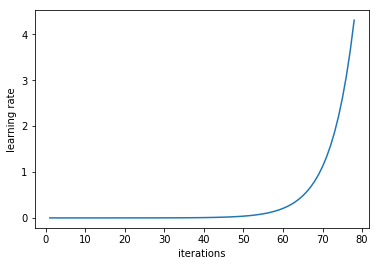

In [22]:
learn.sched.plot_lr()

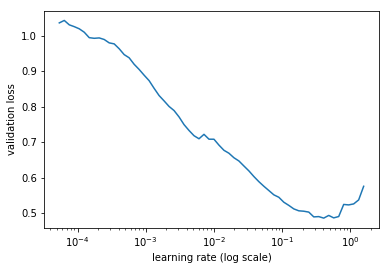

In [23]:
learn.sched.plot()

In [24]:
# Fitting the model
%time learn.fit(5e-2,2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.193781   0.970007   0.794872  
    1      0.143954   1.04921    0.786859                  

CPU times: user 2.33 s, sys: 1.96 s, total: 4.28 s
Wall time: 2.93 s


[array([1.04921]), 0.7868589743589743]

Let's use data augmentation now.

In [25]:
learn.precompute = False

Changing the image size being fed to the network as the smaller images are tending to overfit already.

In [26]:
learn.set_data(get_data(360))

In [27]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.173702   0.753229   0.81891   
    1      0.144799   0.626931   0.842949                  

CPU times: user 10min 3s, sys: 2min 5s, total: 12min 9s
Wall time: 3min 1s


[array([0.62693]), 0.8429487164203937]

Let's save this model.

In [29]:
learn.save('360-resnet50-Pnemonia-LastLayer')

In [35]:
learn.load('360-resnet50-Pnemonia-LastLayer')

Unfreezing the layers of the model and setting a differential learning rate.

In [36]:
learn.unfreeze()

In [37]:
lr = 7e-2

In [38]:
%time learn.fit([lr/9,lr/3,lr], 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.184331   0.644056   0.81891   
    1      0.126245   0.679618   0.873397                  
    2      0.07445    0.568433   0.86859                    
CPU times: user 18min 31s, sys: 3min 11s, total: 21min 43s
Wall time: 7min 15s


[array([0.56843]), 0.8685897451180679]

The model seems to be on the verge of overfitting, so let's save it for now and then run another round on a larger set of images.

In [39]:
learn.save('360-resnet50-Pnemonia-AllLayer')

In [40]:
learn.set_data(get_data(500))

In [41]:
lr = learn.lr_find()

 96%|█████████▋| 79/82 [02:10<00:04,  1.65s/it, loss=0.156] 

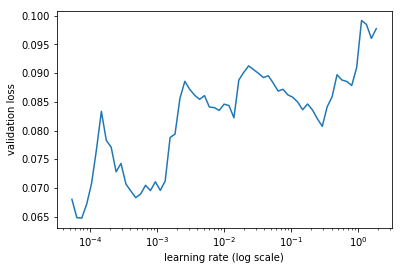

In [42]:
learn.sched.plot()

In [43]:
lr = 1e-1

In [44]:
%time learn.fit([lr/9,lr/3,lr], 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.077036   0.614642   0.865385  
    1      0.08707    0.472836   0.887821                   
    2      0.07013    0.549359   0.878205                   
CPU times: user 21min 27s, sys: 4min 48s, total: 26min 16s
Wall time: 7min 45s


[array([0.54936]), 0.8782051297334524]

In [45]:
learn.save('360-resnet50-Pnemonia-AllLayer2')

In [59]:
learn.load('360-resnet50-Pnemonia-AllLayer2')

Time for some Test-time augmentation and predictions.

In [60]:
log_preds, y = learn.TTA()

In [61]:
probs = np.mean(np.exp(log_preds),0)

In [62]:
accuracy_np(probs, y)

0.8477564102564102

## Confusion Matrix

In [65]:
preds = np.argmax(probs, axis = 1)

In [69]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, auc

In [70]:
cm = confusion_matrix(y, preds)

In [71]:
data.classes

['NORMAL', 'PNEUMONIA']

[[140  94]
 [  1 389]]


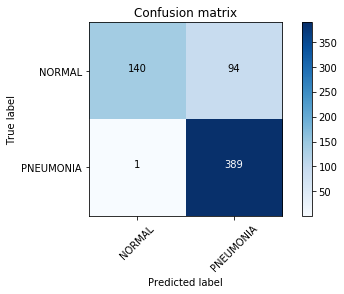

In [72]:
plot_confusion_matrix(cm, data.classes)

In [80]:
recall = recall_score(y, preds)
print(f'Recall: {recall*100} %')
precision = precision_score(y, preds)
print(f'Precision: {precision*100} %')

Recall: 99.74358974358975 %
Precision: 80.53830227743272 %


And we want a model with a high Recall value in such medical cases, as it means that the algorithm has a high value for correctly identifying Pnemonia. But the Precision is not too great here and can be improved.